## 대회설명


### 기초 설명

한국의 약 2,000개 상점의 신용카드 거래 내역이 제공됩니다. card_id를 기준으로 샘플링되었으며, amount의 단위는 KRW가 아닙니다. 테스트 파일에서 각 상점의 마지막 매출 발생일 다음 날부터 100일 후까지 매출의 총합을 예측해야 합니다.

예측한 금액만큼 100일간 대출을 진행합니다. 만약 예측한 금액보다 실제 매출이 적게 발생한다면 원금에 손실을 보게 됩니다. 실제 매출이 예측한 금액 이상으로 발생한다면, 연이율 13%의 이자가 발생합니다.

### Data 설명
train.csv - 카드 매출 내역, 2016-08-01부터 2018-07-31까지.  
test.csv - train.csv랑 같은 형식. test.csv랑 train.csv의 store_id가 같아도 같은 상점인 것은 아님.  
(월에 최소 5일 이상 데이터가 있는 상점만을 문제에 포함.)  
submission.csv – store_id와 total_sales 두 개의 열로 구성. store_id는 test.csv의 store_id와 대응.  

### feature 설명

* store_id : 각 파일에서의 상점 고유 번호 (해당기한 내 개업 혹은 폐업한 상점도 있음)
* date : 거래일자
* time : 거래시간
* card_id : 카드 번호의 hash 값
* amount : 매출 금액, 음수인 경우 취소 거래
* installments : 할부 개월 수. 일시불은 0
* days_of_week : 요일, 월요일이 0, 일요일은 6
* holiday : 1이면 공휴일, 0이면 공휴일 아님

## import / load data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
path = './data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission  = pd.read_csv(path + 'submission.csv')

## Check Simple EDA

In [3]:
# train/test 결합
train['test'] = 0
test['test'] = 1
merge_df = pd.concat([train,test])

In [4]:
merge_df

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,test
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...
473387,199,2018-03-30,14:17:59,300d7bc922,65,NaN,4,0,1
473388,199,2018-03-30,19:01:54,3ab757718b,65,NaN,4,0,1
473389,199,2018-03-30,20:08:03,2d8e9e421c,65,NaN,4,0,1
473390,199,2018-03-30,20:11:58,22daeb334e,200,NaN,4,0,1


### 결측치/이상치탐색

#### 결측치 파악
* train/test에서 결측치는 파악되지 않는 것으로 보임
* installments에서 결측치는 0이라 언급된바 있으므로 0으로 대체

In [5]:
def info_df(data):
    '''data의 type, null_count, null_rate를 알려주는 함수
    
    Parameter
    ---------
    data(DataFrame) : 파악하고자하는 Data
       
    '''
    info_df = pd.DataFrame({"type":data.dtypes,
                            'null_count':data.isnull().sum(),
                           'null_rate':data.isnull().sum()/data.isnull().count() * 100})  
    info_df['uni_count'] = data.apply(lambda x : x.nunique())
    
    return info_df

In [6]:
info_df(merge_df)

,type,null_count,null_rate,uni_count
store_id,int64,0,0.000000,1778
date,object,0,0.000000,730
time,object,0,0.000000,86058
card_id,object,0,0.000000,999836
amount,int64,0,0.000000,6249
installments,float64,3817549,99.514127,16
days_of_week,int64,0,0.000000,7
holyday,int64,0,0.000000,2
test,int64,0,0.000000,2


In [7]:
merge_df.installments.fillna(0,inplace = True)

#### 이상치 탐색

In [8]:
#날짜
merge_df.date.min(), merge_df.date.max()

('2016-08-01', '2018-07-31')

In [9]:
#시간
merge_df.time.min(), merge_df.time.max()

('00:00:00', '23:59:59')

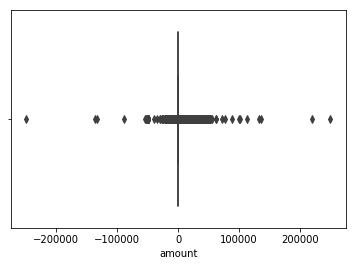

In [10]:
#거래금액
sns.boxplot(merge_df.amount)

### 날짜
* 주기적으로 특정일자에 매출이 감소함

C:\Users\try00\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


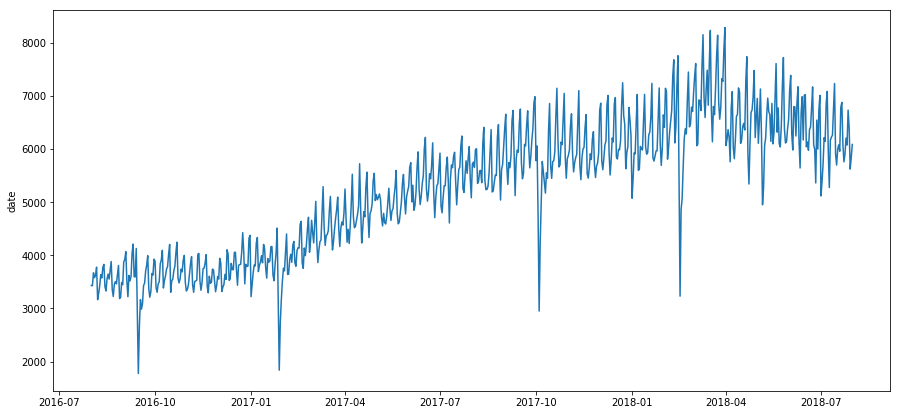

In [11]:
#object -> datetime으로 전환
merge_df['date'] = pd.to_datetime(merge_df.date)
dates = merge_df['date'].value_counts().sort_index()

plt.figure(figsize=(15,7))
sns.lineplot(x = dates.index, y = dates)
plt.show()

#### 연도별 최소점/최대점을 찍은 날짜?
* 각 일자는 명절, 명절에는 소비횟수가 급감하는 형태를 보임
* 2016.09.15 추석, 2017-01-28 설날, 2018-02-16 설날
* 크리스마스에 소비횟수가 집중

In [12]:
merge_df['year'] = merge_df['date'].apply(lambda x : x.year)
merge_df['month'] = merge_df['date'].apply(lambda x : x.month)

In [13]:
for year in merge_df.year.unique():
    imsi = merge_df.loc[merge_df.year == year,'date'].value_counts()
    print('최저 일자:',imsi.idxmin(), '최저일자의 거래횟수:',imsi.min())

최저 일자: 2016-09-15 00:00:00 최저일자의 거래횟수: 1777
최저 일자: 2017-01-28 00:00:00 최저일자의 거래횟수: 1839
최저 일자: 2018-02-16 00:00:00 최저일자의 거래횟수: 3232


In [14]:
for year in merge_df.year.unique():
    imsi = merge_df.loc[merge_df.year == year,'date'].value_counts()
    print('최대 일자:',imsi.idxmax(), '최대일자의 거래횟수:',imsi.max())

최대 일자: 2016-12-24 00:00:00 최대일자의 거래횟수: 4427
최대 일자: 2017-12-23 00:00:00 최대일자의 거래횟수: 7246
최대 일자: 2018-03-31 00:00:00 최대일자의 거래횟수: 8284


#### 일자별 평균 소비금액
* 2016년의 경우 추석 전날인 09-13에 가장 평균 소비금액이 높고, 당일인 09-15에 가장 낮았다
* 2017-10-04는 추석이나 1~9까지 휴일(약 9~10일 휴일) , 2018-06-17은 일요일

In [15]:
daily_amount = merge_df[merge_df.amount>0].groupby('date')['amount'].mean()

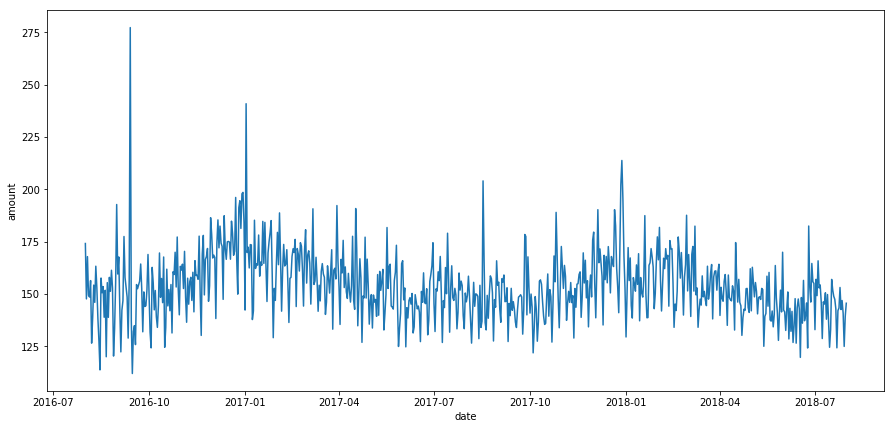

In [16]:
plt.figure(figsize=(15,7))
sns.lineplot(x = daily_amount.index, y = daily_amount)
plt.show()

In [17]:
daily_amount = daily_amount.reset_index()
daily_amount['year'] = daily_amount['date'].apply(lambda x : x.year)
daily_amount.set_index('date',inplace=True)

In [18]:
for year in daily_amount.year.unique():
    imsi = daily_amount.loc[daily_amount.year == year,'amount']
    print('최소 일자:',imsi.idxmin(), '최소일자의 평균거래금액:',imsi.min())

최소 일자: 2016-09-15 00:00:00 최소일자의 평균거래금액: 111.99716392512762
최소 일자: 2017-10-04 00:00:00 최소일자의 평균거래금액: 121.86028149673875
최소 일자: 2018-06-17 00:00:00 최소일자의 평균거래금액: 119.69896597731821


In [19]:
for year in daily_amount.year.unique():
    imsi = daily_amount.loc[daily_amount.year == year,'amount']
    print('최대 일자:',imsi.idxmax(), '최대일자의 평균거래금액:',imsi.max())

최대 일자: 2016-09-13 00:00:00 최대일자의 평균거래금액: 277.2604242867593
최대 일자: 2017-01-02 00:00:00 최대일자의 평균거래금액: 240.88826815642457
최대 일자: 2018-02-28 00:00:00 최대일자의 평균거래금액: 187.6021260440395


#### store별 마지막 거래일자
* train 기준 2016-08-10부터 2018-07-31일까지 꾸준히 있고, 2018-07-31쪽에 집중되어 있음
* test 기준 2018-01-17부터 2018-03-31일까지 꾸준히 있고 2018-03-31쪽에 집중되어 있음 

##### train

In [20]:
final_sale_train = merge_df[merge_df['test'] == 0].groupby('store_id')['date'].max()

In [21]:
final_sale_train.min(),final_sale_train.max()

(Timestamp('2016-08-10 00:00:00'), Timestamp('2018-07-31 00:00:00'))

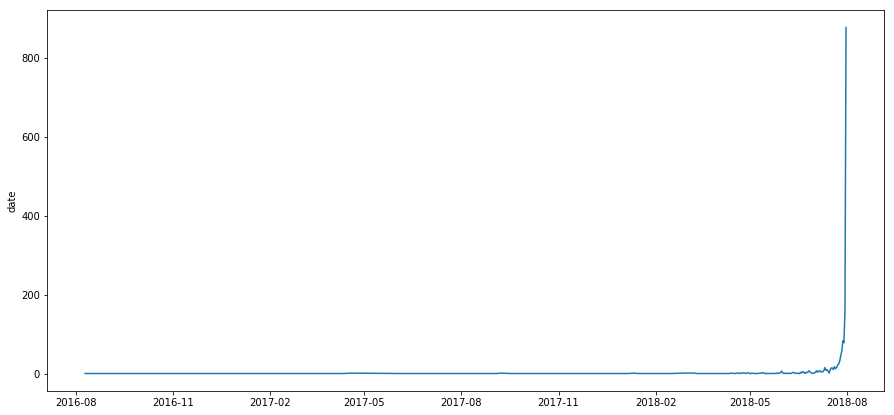

In [22]:
dates = final_sale_train.value_counts()
plt.figure(figsize=(15,7))
sns.lineplot(x = dates.index, y = dates)
plt.show()

##### test

In [23]:
final_sale_test = merge_df[merge_df['test'] == 1].groupby('store_id')['date'].max()

In [24]:
final_sale_test.min(),final_sale_test.max()

(Timestamp('2018-01-17 00:00:00'), Timestamp('2018-03-31 00:00:00'))

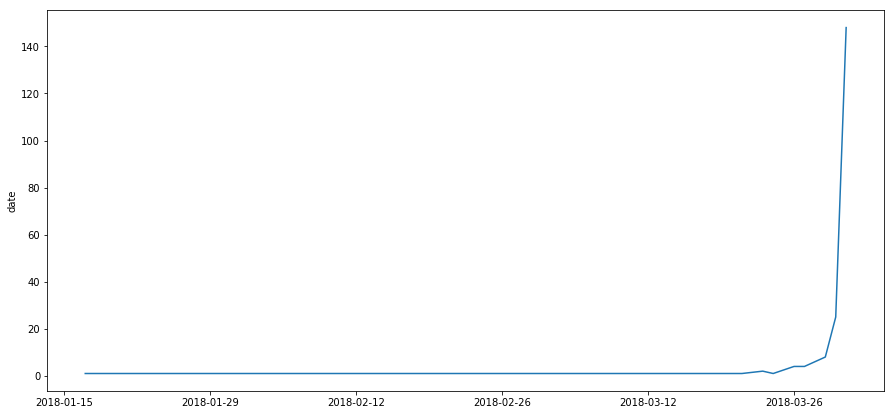

In [25]:
dates = final_sale_test.value_counts()
plt.figure(figsize=(15,7))
sns.lineplot(x = dates.index, y = dates)
plt.show()

##### 제외해야할 data
* train의 경우 마지막거래일자에서 100일전이 2016-08-01 보다 빠른경우 아웃라이어

In [26]:
day_check = final_sale_train - datetime.timedelta(100)

In [27]:
merge_df.date.min()

Timestamp('2016-08-01 00:00:00')

In [28]:
day_check[day_check > merge_df.date.min()]

store_id
0      2018-04-22
1      2018-03-24
2      2018-04-22
3      2018-04-21
4      2018-04-20
          ...    
1795   2018-04-22
1796   2018-04-22
1797   2018-04-22
1798   2018-04-22
1799   2018-04-21
Name: date, Length: 1772, dtype: datetime64[ns]

### time
* 오전 시간대 매출이 가장 적고, 그다음은 14-16시 이전이다

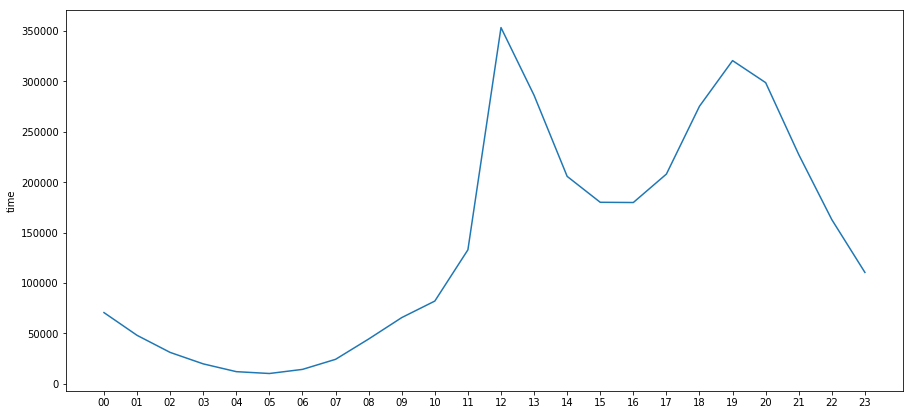

In [43]:
hours = train.time.apply(lambda x :x[:2])
hours = hours.value_counts().sort_index()

plt.figure(figsize = (15,7))
sns.lineplot(x = hours.index, y = hours)
plt.show()

### amount
* 음수는 환불 따라서 refurn 컬럼을 만들어주고 refurn은 0으로 변환

#### 거래금액이 0인 경우는 뭘까?
* 전체 1115개가 존재. 오류라고 생각하기엔 다소 이상하다
* train/test셋에서 동일한 비율로 발생 
* 가정1 : (의미 있다) 할인쿠폰등을 사용하면 거래금액이 0이 발생할 수 있을까
* 가정2 : (의미 없다) 오류 혹은 의미가 없을 것  
-> 일단 가정 2로 진행

In [129]:
tt = merge_df.loc[merge_df.test ==1]
zero_store = tt.loc[tt.amount ==0,'store_id'].value_counts().shape[0]
all_store = tt.store_id.nunique()
rate = round(zero_store/all_store,2) *100
print(f"(test셋)매출 0이 발생한 매장수: {zero_store}, 전체 매장수 : {all_store}, 비율 :{rate}")

(test셋)매출 0이 발생한 매장수: 35, 전체 매장수 : 200, 비율 :17.0


In [131]:
tt = merge_df.loc[merge_df.test ==0]
zero_store = tt.loc[tt.amount ==0,'store_id'].value_counts().shape[0]
all_store = tt.store_id.nunique()
rate = round(zero_store/all_store,2) *100
print(f"(train셋)매출 0이 발생한 매장수: {zero_store}, 전체 매장수 : {all_store}, 비율 :{rate}")

(train셋)매출 0이 발생한 매장수: 311, 전체 매장수 : 1775, 비율 :18.0


In [133]:
merge_df.loc[merge_df.amount <0, 'refund'] = 1
merge_df.loc[merge_df.amount >0, 'refund'] = 0
merge_df.loc[merge_df.amount <0, 'amount'] = 0

In [115]:
merge_df.amount.max()

250000

### installment_term
* 일시불의 비율이 96%이상, 할부의 비중은 1년이하가 가장많다

In [44]:
train['installment_cut'] = 0
train.installments.fillna(0,inplace = True)
train.loc[(train.installments>0)&(train.installments<13),'installment_cut'] = 1
train.loc[(train.installments>12)&(train.installments<25),'installment_cut'] = 2
train.loc[(train.installments>24)&(train.installments<37),'installment_cut'] = 3
train.loc[(train.installments>36),'installment_cut'] = 4

In [45]:
train['installment_cut'].value_counts(normalize=True)

0    0.994986
1    0.004977
2    0.000035
3    0.000001
Name: installment_cut, dtype: float64

In [46]:
train.loc[train['installments'] > 0,'installments_bool'] = 1
train.loc[train['installments'] == 0,'installments_bool'] = 0

### 요일
* 0이 월요일이고, 6이 일요일
* 금토에 소비횟수가 가장많고, 일요일이 가장 소비횟수가 적음
* 평균소비금액은 평일에는 큰 차이가 없고 (월요일 다소 적음) 오히려 주말에 다소 감소

#### 소비횟수

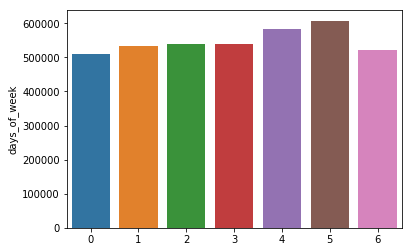

In [29]:
weeks = merge_df.days_of_week.value_counts()

sns.barplot(x = weeks.index, y = weeks)
plt.show()

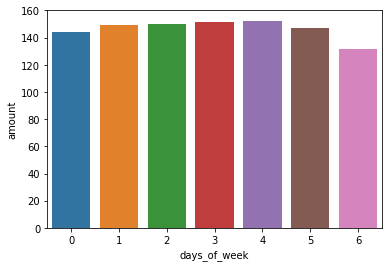

In [30]:
#평균 소비금액 
weekly_amount = merge_df.groupby('days_of_week')['amount'].mean()
sns.barplot(x = weekly_amount.index, y= weekly_amount)

### holyday
* 휴일이 아닐때 소비횟수 및, 소비금액이 평균적으로 더 높음

In [31]:
un_holydays = merge_df.loc[merge_df.holyday == 0,'date'].nunique()
holydays = merge_df.loc[merge_df.holyday == 1,'date'].nunique()

mean_unholydays = merge_df.holyday.value_counts()[0]/un_holydays
mean_holydays = merge_df.holyday.value_counts()[1]/holydays

mean_holydays_df = pd.DataFrame([mean_unholydays,mean_holydays],columns=['holydays'],index = [0,1])

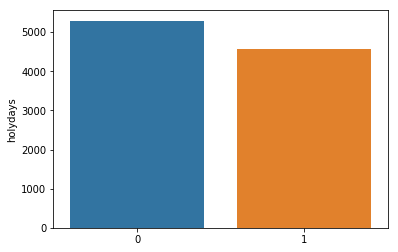

In [32]:
# 소비횟수 비교 
sns.barplot(mean_holydays_df.index,mean_holydays_df['holydays'])
plt.show()

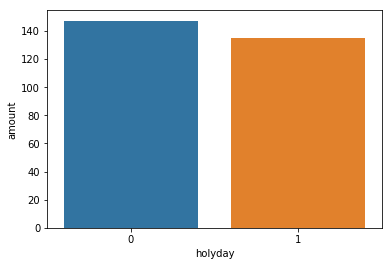

In [33]:
# 소비금액 비교
holy_amount = merge_df.groupby('holyday')['amount'].mean()
sns.barplot(x = holy_amount.index, y = holy_amount)
plt.show()

#### holyday 구성은 어떻게되어있나?
* 01-01 신정, (음력)01-01 설날, 03-01 삼일절, (음력)04-08 부처님 오신날, 05-01 근로자의날, 05-05 어린이날, 06-06 현충일, 
* 08-15 광복절, (음력) 08-15 추석, 10-03 개천절, 10-09 한글날, 12-25 크리스마스 
* 17-05-09 국회의원선거, 17-10-02 임시공휴일, 18-06-13 지방선거
* 17-10-06 대체공휴일(추석 전날(10월 3일)이 국경일이자 법정공휴일인 개천절과 겹치면서), 18-05-07 어린이날대체휴일
* 연휴 16-09-14~16, 17-01-27~29, 17-10-02~09 황금연휴, 18-02-15~17  
-> test 마지막 거래일자 2018-03-31이므로 약 2018-06-09 정도까지의 공휴일데이터 필요 (특별히 더 추가할 필요는 없어보임)  
-> 미래확장성을 감안하면 자동으로 공휴일 계산해주면 좋을듯 (임시공유일은 추가확정성기능으로)

In [34]:
#test마지막 일자에서 100일후 
datetime.datetime(2018,3,1) + datetime.timedelta(100)

datetime.datetime(2018, 6, 9, 0, 0)

In [35]:
#요일 오류 확인(이상무)
check_week = merge_df.date.apply(lambda x : x.weekday())
merge_df[merge_df.days_of_week != check_week]

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,test,year,month


In [36]:
holydays_df = merge_df[merge_df.holyday == 1]

In [41]:
holydays_df.drop_duplicates('date').sort_values('date')

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,test,year,month
69090,2,2016-08-15,07:03:51,b8f4039073,60,0.0,0,1,0,2016,8
69759,2,2016-09-14,00:15:29,ee292ccc5b,80,0.0,2,1,0,2016,9
91125,8,2016-09-15,00:39:22,0b5c785944,240,0.0,3,1,0,2016,9
69770,2,2016-09-16,13:01:01,f429965e15,80,0.0,4,1,0,2016,9
70160,2,2016-10-03,08:58:05,2543aabcbf,40,0.0,0,1,0,2016,10
70294,2,2016-10-09,05:16:38,28a7a96d24,600,0.0,6,1,0,2016,10
772,0,2016-12-25,00:23:22,7df04debf0,79,0.0,6,1,0,2016,12
1635,0,2017-01-01,00:27:46,1e3035e497,36,0.0,6,1,0,2017,1
4588,0,2017-01-27,00:06:14,8892c23a23,30,0.0,4,1,0,2017,1
4732,0,2017-01-28,00:47:57,a697ba76a9,20,0.0,5,1,0,2017,1


In [134]:
all_dates = merge_df.drop_duplicates('date').sort_values('date')
all_dates = all_dates[['date','days_of_week','holyday']]
all_dates.reset_index(drop=True, inplace=True)